In [1]:
%run init_notebook.py
from settings import DATA_DIR

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from scipy.stats import normaltest
import scipy

In [3]:
from src.utils import *
from src.pymc_modelling import get_VAR_arr, get_samp, get_pymc_mod_table

In [4]:
# load data

In [6]:
# cpi = get_dt_index(load_pd_df('cpi.csv'), 'Unnamed: 0')
cpi = load_pd_df('cpi.feather')
cpi.index.name = 'date'

In [7]:
# train test split

In [8]:
t = cpi.index.dropna().date
cpi['t'] = np.array((t - t.min()) / (t.max() - t.min()))

_train = cpi.dropna().loc[datetime(2010,1,1):datetime(2020,3,1)].copy()
_test = cpi.dropna().loc[datetime(2020,3,1):].copy()

t, y = _train['t'].values.astype(float), _train['pi_de'].values.astype(float)
t_test, y_test = _test['t'].values.astype(float), _test['pi_de'].values.astype(float)
t_all, y_all = np.concatenate([t, t_test]), np.concatenate([y, y_test])

In [9]:
# seasonal

In [10]:
n_order = 10
periods = _train.reset_index()['date'].dropna().dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

periods = _test.reset_index()['date'].dropna().dt.dayofyear / 365.25
fourier_features_test = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
# fourier_features

In [11]:
n_lags = 4
y_lag = get_VAR_arr(y[:,None], n_lags)

coords = {"fourier_features": np.arange(2 * n_order), "n_lags": range(0, n_lags)}
with pm.Model(check_bounds=False, coords=coords) as ar_lin_seas:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    
    rho = pm.Beta('rho', mu=.22, sigma=.11, shape=(n_lags,))
    beta_f = pm.Normal("beta_f", mu=1, sigma=10, dims="fourier_features")
    
    seasonality = pm.Deterministic("seasonality", pm.math.dot(beta_f, fourier_features.iloc[:-n_lags].to_numpy().T))
    trend = pm.Deterministic("trend", alpha + t[:-n_lags] * beta)
    ar_p = pm.Deterministic("AR", y_lag @ rho)
    mu = trend * (1 + seasonality) + ar_p
        
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y[:-n_lags])

    ar_lin_seas_prior = pm.sample_prior_predictive()

Sampling: [alpha, beta, beta_f, likelihood, rho, sigma]


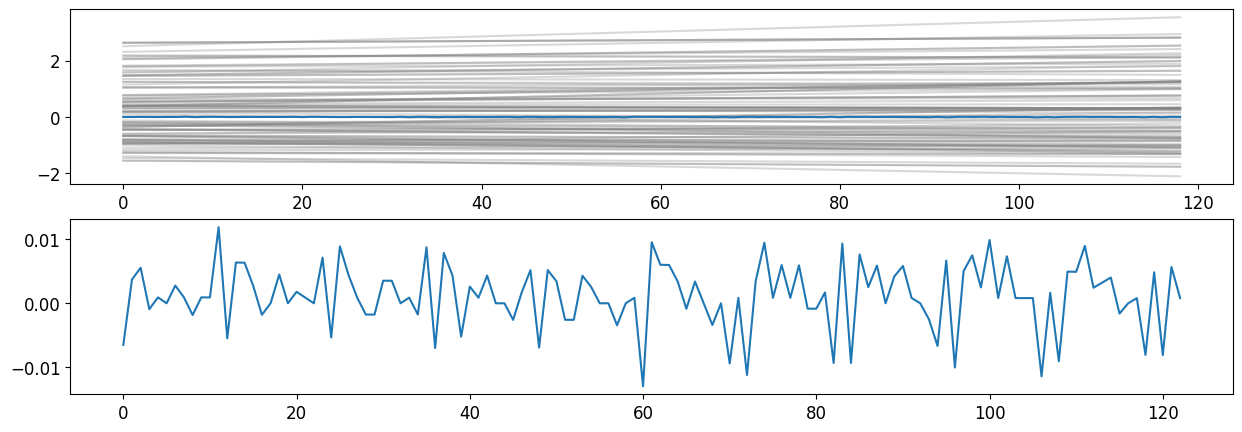

In [12]:
fig, ax = plt.subplots(2,1, figsize=(15,5))
ax[0].plot(
    ar_lin_seas_prior.prior['trend'][0, get_samp(200)].T,
    alpha=.3, color='grey'
)
ax[0].plot(y[n_lags:])
ax[1].plot(y);

In [13]:
with ar_lin_seas:
    ar_lin_seas_post = pm.sample(nuts_sampler="numpyro", return_inferencedata=True, idata_kwargs = {'log_likelihood': True})
    ar_lin_seas_post_pred = pm.sample_posterior_predictive(ar_lin_seas_post)

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:07.186880
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:27.469856
Transforming variables...
Transformation time =  0:00:00.696388
Computing Log Likelihood...
Log Likelihood time =  0:00:01.604666


Sampling: [likelihood]


In [14]:
x = az.waic(ar_lin_seas_post)

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


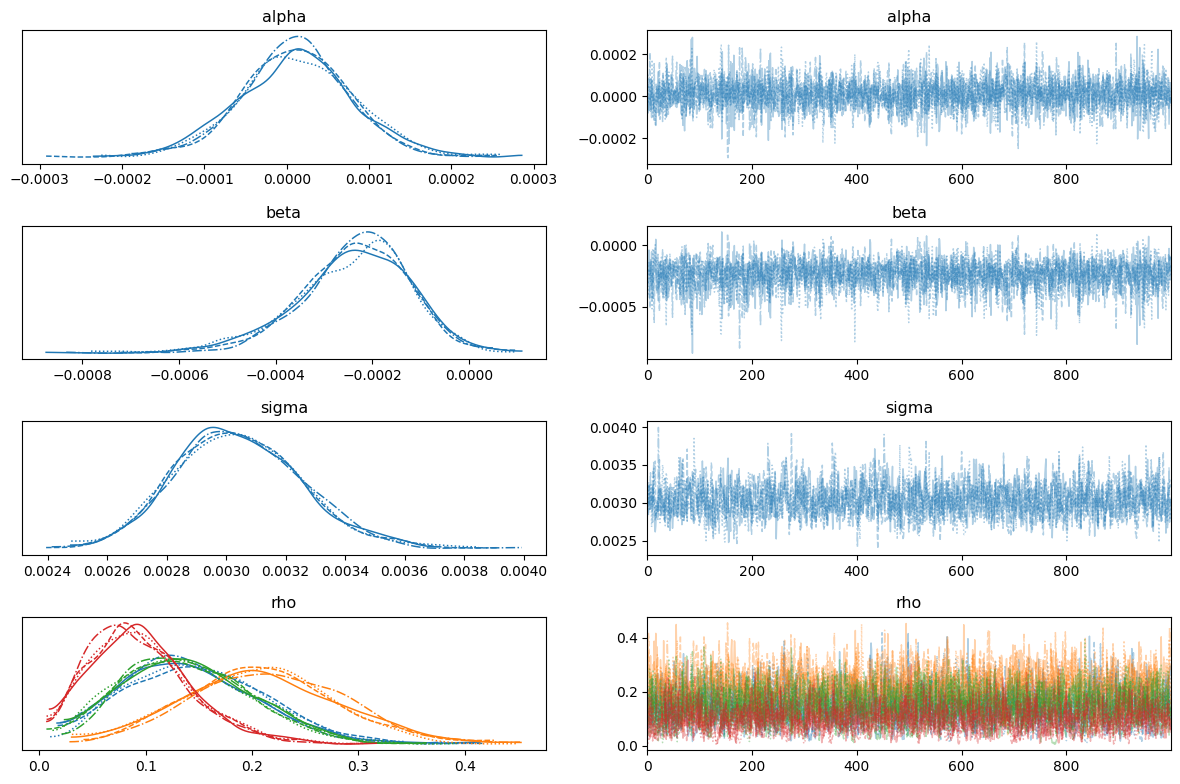

In [15]:
az.plot_trace(ar_lin_seas_post, var_names=['alpha', 'beta', 'sigma', 'rho',])
plt.tight_layout();

In [32]:
samp = ar_lin_seas_post_pred.posterior_predictive['likelihood']
resid = (y[:-n_lags] - samp[0, get_samp(1_000, 200), :].T.median(axis=1)).values

In [33]:
# get table for estimates

In [38]:
# get_pymc_mod_table(ar_lin_seas_post, lst_params=['alpha', 'beta', 'beta_f', 'sigma', 'rho',], seperator=" ").round(3)

In [39]:
# save_pd_df(
#     get_pymc_mod_table(ar_lin_seas_post, lst_params=['alpha', 'beta', 'beta_f', 'sigma', 'rho',], seperator=" ").round(3),
#     'tab_pi_pymc.csv',
#     GRAPHS_DIR
# )

In [40]:
# forecast

In [41]:
samp = ar_lin_seas_post.posterior

In [42]:
trend = samp['alpha'][:, get_samp(1_000, 100)].values.ravel()[None] \
        + t_test[:,None] @ samp['beta'][:, get_samp(1_000, 100)].values.ravel()[None]

ar = get_VAR_arr(y_all[:, None], n_lags)[-len(t_test):] @ samp['rho'][:, get_samp(1_000, 100)].values.reshape(400, n_lags).T
season = (samp['beta_f'].values[:, get_samp(1_000, 100)].reshape(400, 20) @ fourier_features_test.to_numpy().T).T

forecast = trend * (1 + season) + ar
resid_test = y_test - forecast.mean(axis=1)

In [43]:
# nice plot

In [44]:
samp = ar_lin_seas_post_pred.posterior_predictive['likelihood']

data_mod = samp[:, get_samp(1_000, 100), :].values.reshape(400, len(y)-n_lags)
data_forecast = np.concatenate([np.zeros((400, len(y)-n_lags)) * np.nan, forecast.T], axis=1)

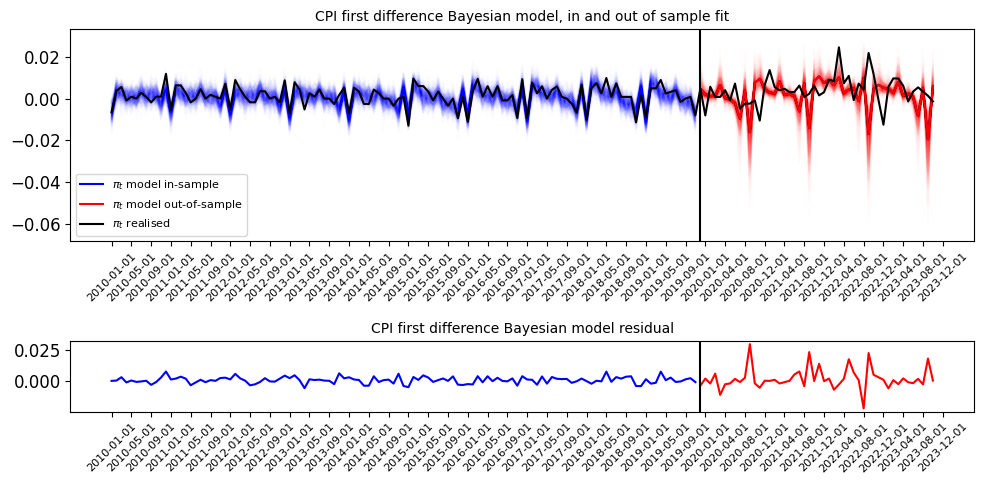

In [45]:
fig, ax = plt.subplots(2,1, figsize=(10,5), gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(data_mod.T, alpha=.0075, color='blue',)
ax[0].plot(data_forecast.T.mean(axis=1), color='blue', label='$\pi_t$ model in-sample')

ax[0].plot(data_forecast.T, alpha=.0075, color='red')
ax[0].plot(data_forecast.T.mean(axis=1), color='red', label="$\pi_t$ model out-of-sample")

ax[0].plot(y_all[:-n_lags], color='black',  label="$\pi_t$ realised")

ax[1].plot(resid, color='blue')
ax[1].plot(np.concatenate([np.zeros(len(y[:-n_lags])) * np.nan, resid_test]), color='red')

ax[1].plot()

ax[0].axvline(len(y[:-n_lags]), color='black')
ax[1].axvline(len(y[:-n_lags]), color='black')

ax[0].set_title('CPI first difference Bayesian model, in and out of sample fit', size=10,)
ax[1].set_title('CPI first difference Bayesian model residual', size=10)

idx = [*chain(list(_train.index), list(_test.index))]

ax[0].set_xticks([*range(0, len(idx))][0::4])
ax[0].set_xticklabels([i.date() for i in idx][0::4], rotation=45, size=8)

ax[1].set_xticks([*range(0, len(idx))][0::4])
ax[1].set_xticklabels([i.date() for i in idx][0::4], rotation=45, size=8)

ax[0].legend(loc='lower left', prop={'size': 8})

plt.tight_layout()
# fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph1.png'));

''

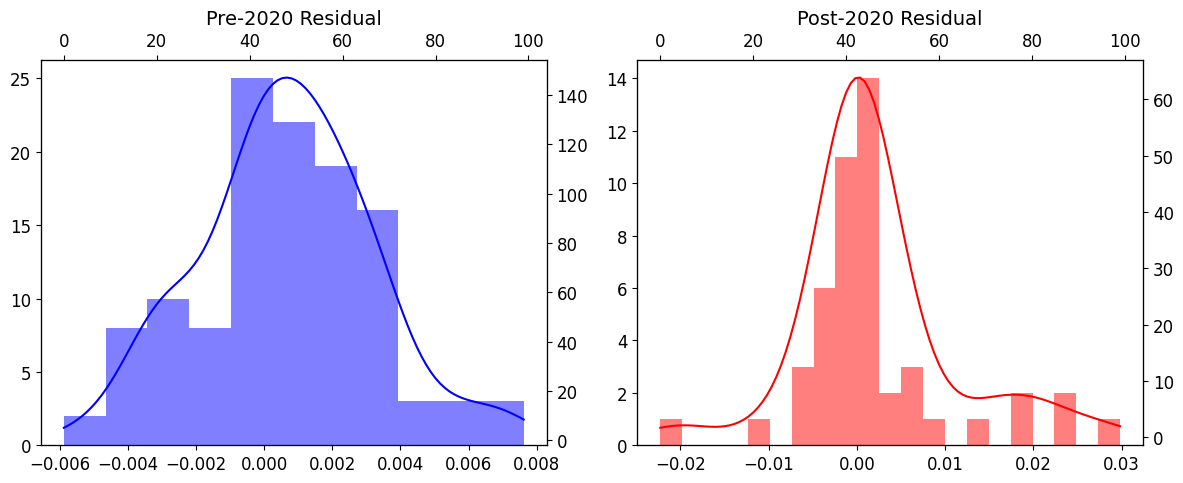

In [46]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))

ax[0].hist(resid, bins='fd', density=False, label='pre-2020', alpha=.5, color='blue', )
ax[0].twiny().twinx().plot([scipy.stats.gaussian_kde(resid).pdf(i) for i in np.linspace(*ax[0].get_xlim(), 100)], color='blue')

ax[1].hist(resid_test, bins='fd', density=False, label='pos-2020', alpha=.5, color='red')
ax[1].twiny().twinx().plot([scipy.stats.gaussian_kde(resid_test).pdf(i) for i in np.linspace(*ax[1].get_xlim(), 100)], color='red')

ax[0].set_title(f'Pre-2020 Residual', size=14)
ax[1].set_title(f'Post-2020 Residual', size=14)

fig.tight_layout()
# fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_graph2.png'))
;

In [47]:
# merge data

In [48]:
_train['is_train'] = np.zeros(len(_train)) + True
_test['is_train'] = np.zeros(len(_test)) + False

df = pd.concat([_train, _test], axis=0).copy()
df = df.iloc[:-1]
df['is_train'] = df.is_train.astype(bool)

df['pi_de_surprise'] = np.concatenate([np.ones(n_lags-1) * np.nan, resid, resid_test])

arr = np.concatenate(
    [
        np.ones(n_lags-1) * np.nan,
        ar_lin_seas_post_pred.posterior_predictive.likelihood.values[:, get_samp(1_000, 100)].mean(axis=(0,1)),
        forecast.mean(axis=1)
    ]
)

df['pi_de_estimate'] = arr
df.drop('t', axis=1, inplace=True)

In [49]:
# annual inflation

In [50]:
# get annual inflation
df = df.join(
    df[['pi_de', 'pi_de_estimate', 'pi_de_surprise']].rolling(12).apply(lambda x: np.prod(x + 1) - 1).add_suffix('_Y')
)

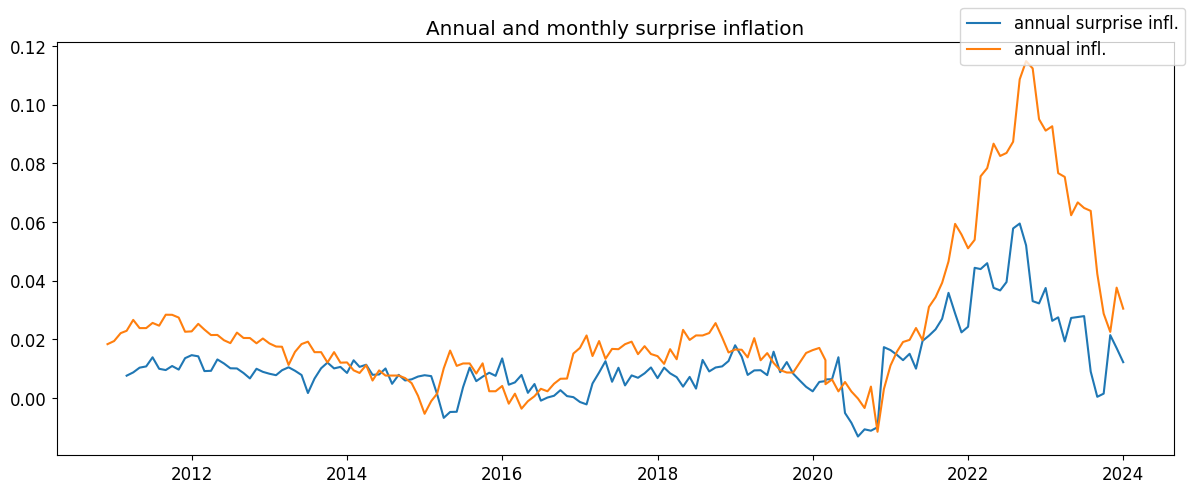

In [51]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(df.pi_de_surprise_Y, label='annual surprise infl.')
ax.plot(df.pi_de_Y, label='annual infl.')
# ax.plot(df.pi_de_surprise, label='monthly surprise infl.')
# ax.plot(df.pi_de_Y, label='realised infl.')

fig.legend()
ax.set_title('Annual and monthly surprise inflation')

plt.tight_layout()

# fig.savefig(os.path.join(GRAPHS_DIR, 'presentation3_surp_infl.png'))

In [74]:
## no autocorrelation

In [75]:
from src.processing import xcorr
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest, ttest_1samp

In [76]:
### in sample

In [109]:
def get_print(pval, stat, sep: str = "\n", n_round: int = 3):
    return str(round(pval, n_round)) + get_stars(pval) + sep + "[" + str(round(stat, n_round)) + "]"

In [129]:
test_dict = {}
for k, d in {
    'in_samp_resid': df[df.is_train]['pi_de_surprise'],
    'out_samp_resid': df[~df.is_train]['pi_de_surprise'],
    'in_samp_hat': df[df.is_train]['pi_de_estimate'],
    'out_samp_hat': df[~df.is_train]['pi_de_estimate'],
}.items():
    _dict = {}
    
    # H0: no autocorrelation
    res = list(acorr_ljungbox(d.dropna(), model_df=1).loc[3].values)
    _dict['acorr'] = dict(zip(['stat', 'pval'], res))
    _dict['acorr']['print'] = get_print(res[1], res[0])
    
    # H0: sample is normal
    res =  list(scipy.stats.normaltest(d.dropna()))
    _dict['norm'] = dict(zip(['stat', 'pval'], res))
    _dict['norm']['print'] = get_print(res[1], res[0])
    
    test_dict[k] = _dict

In [130]:
res = pd.concat(
    [pd.DataFrame(test_dict[k]).T['print'].rename(k) for k in test_dict.keys()],
    axis=1
)

In [132]:
save_pd_df(res, "tab_pi_acorr.csv")

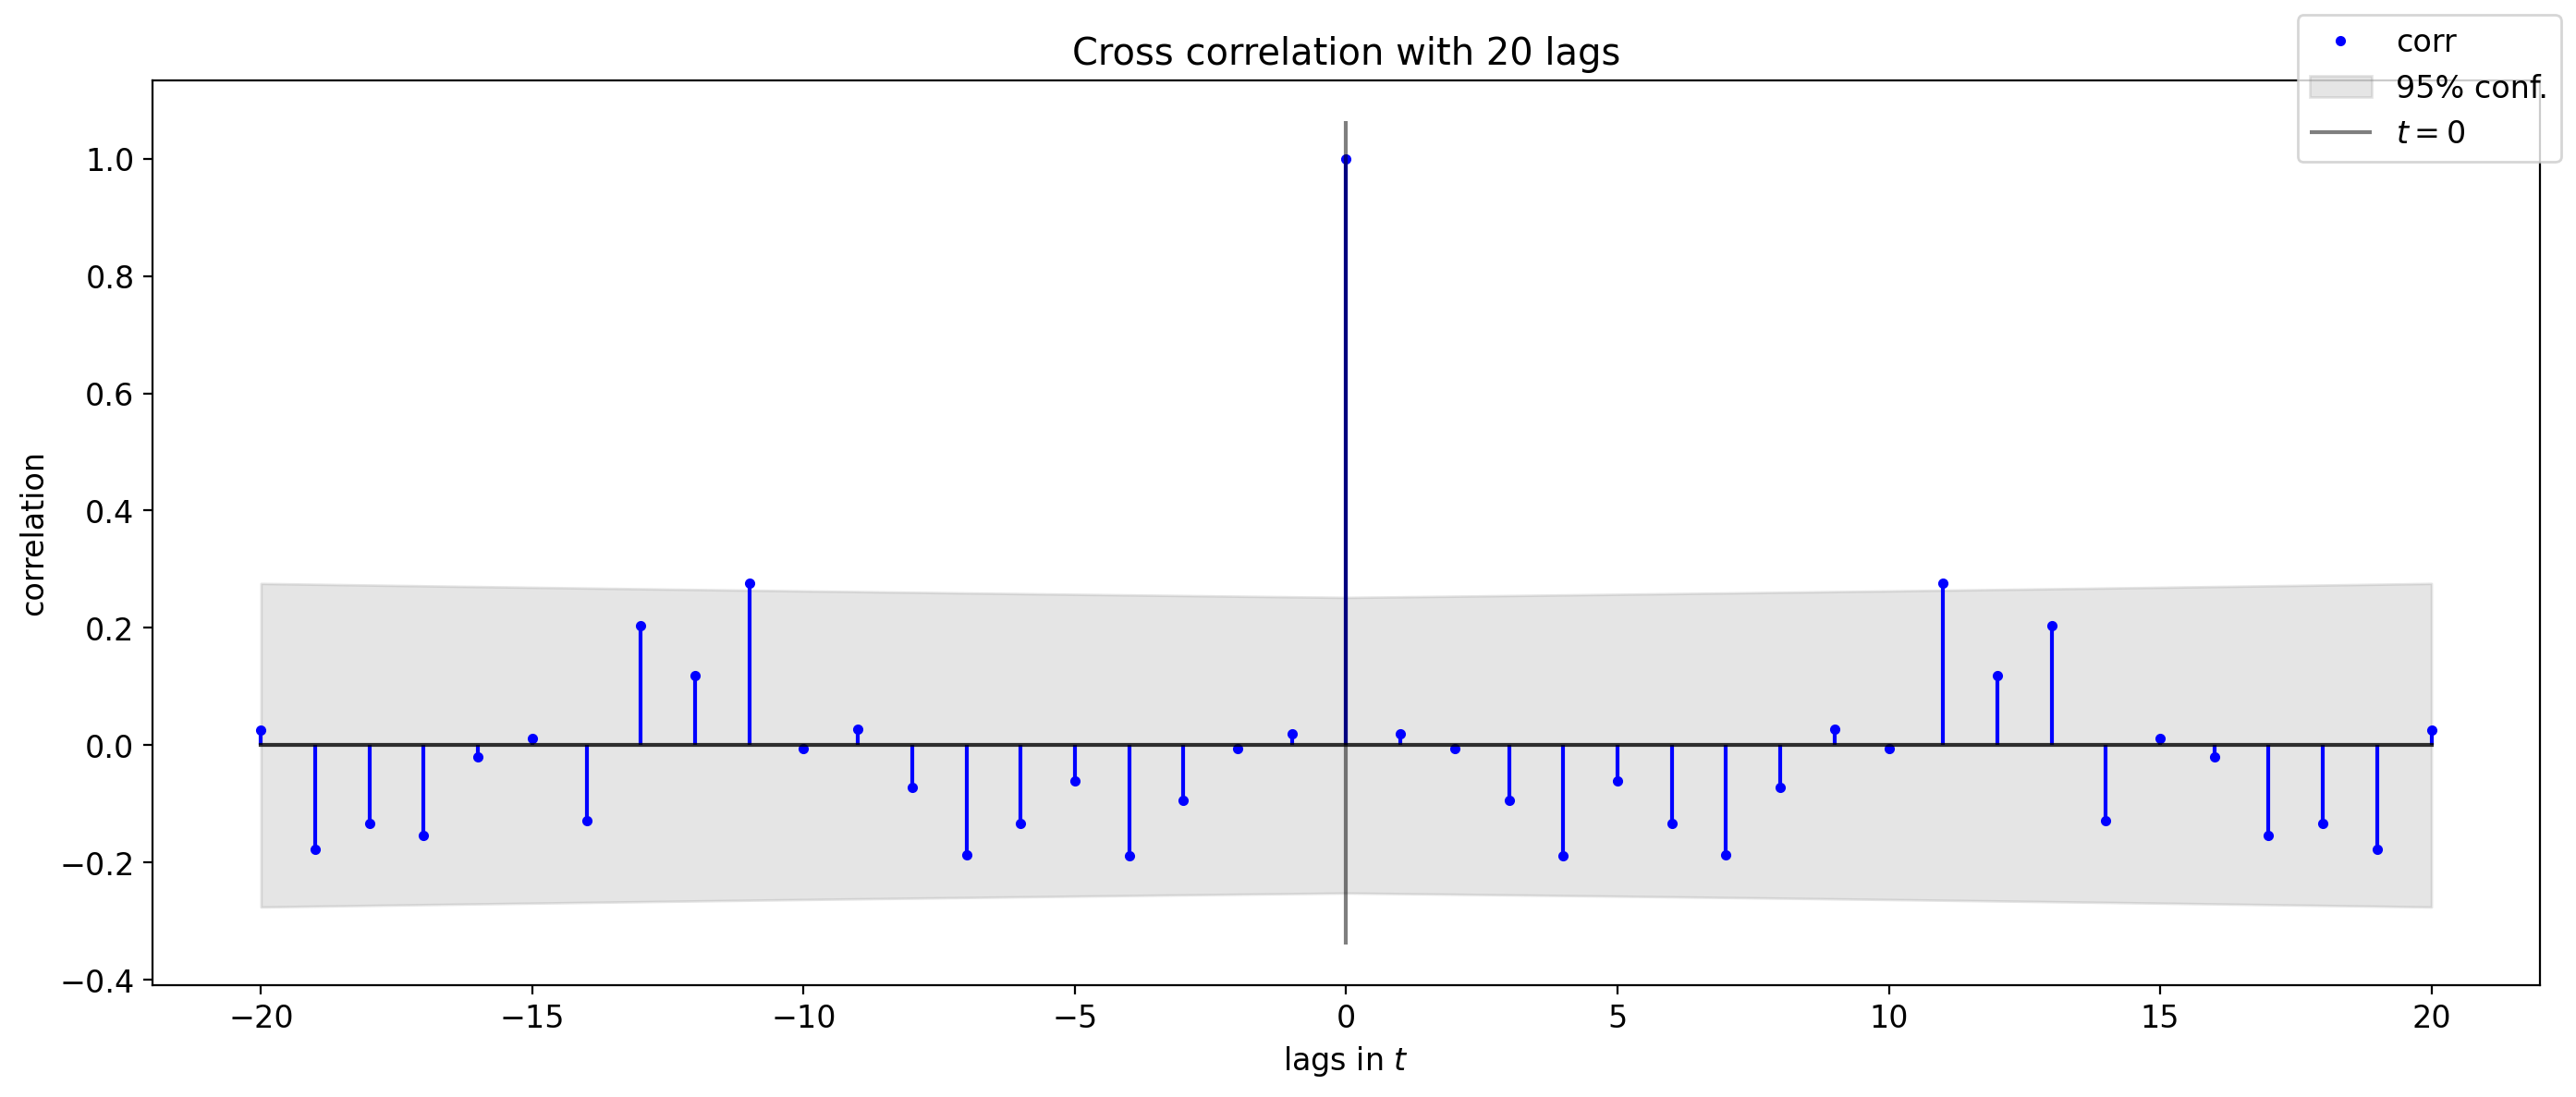

In [133]:
xcorr(df[df.is_train]['pi_de_surprise'].dropna(), n_lags=20);

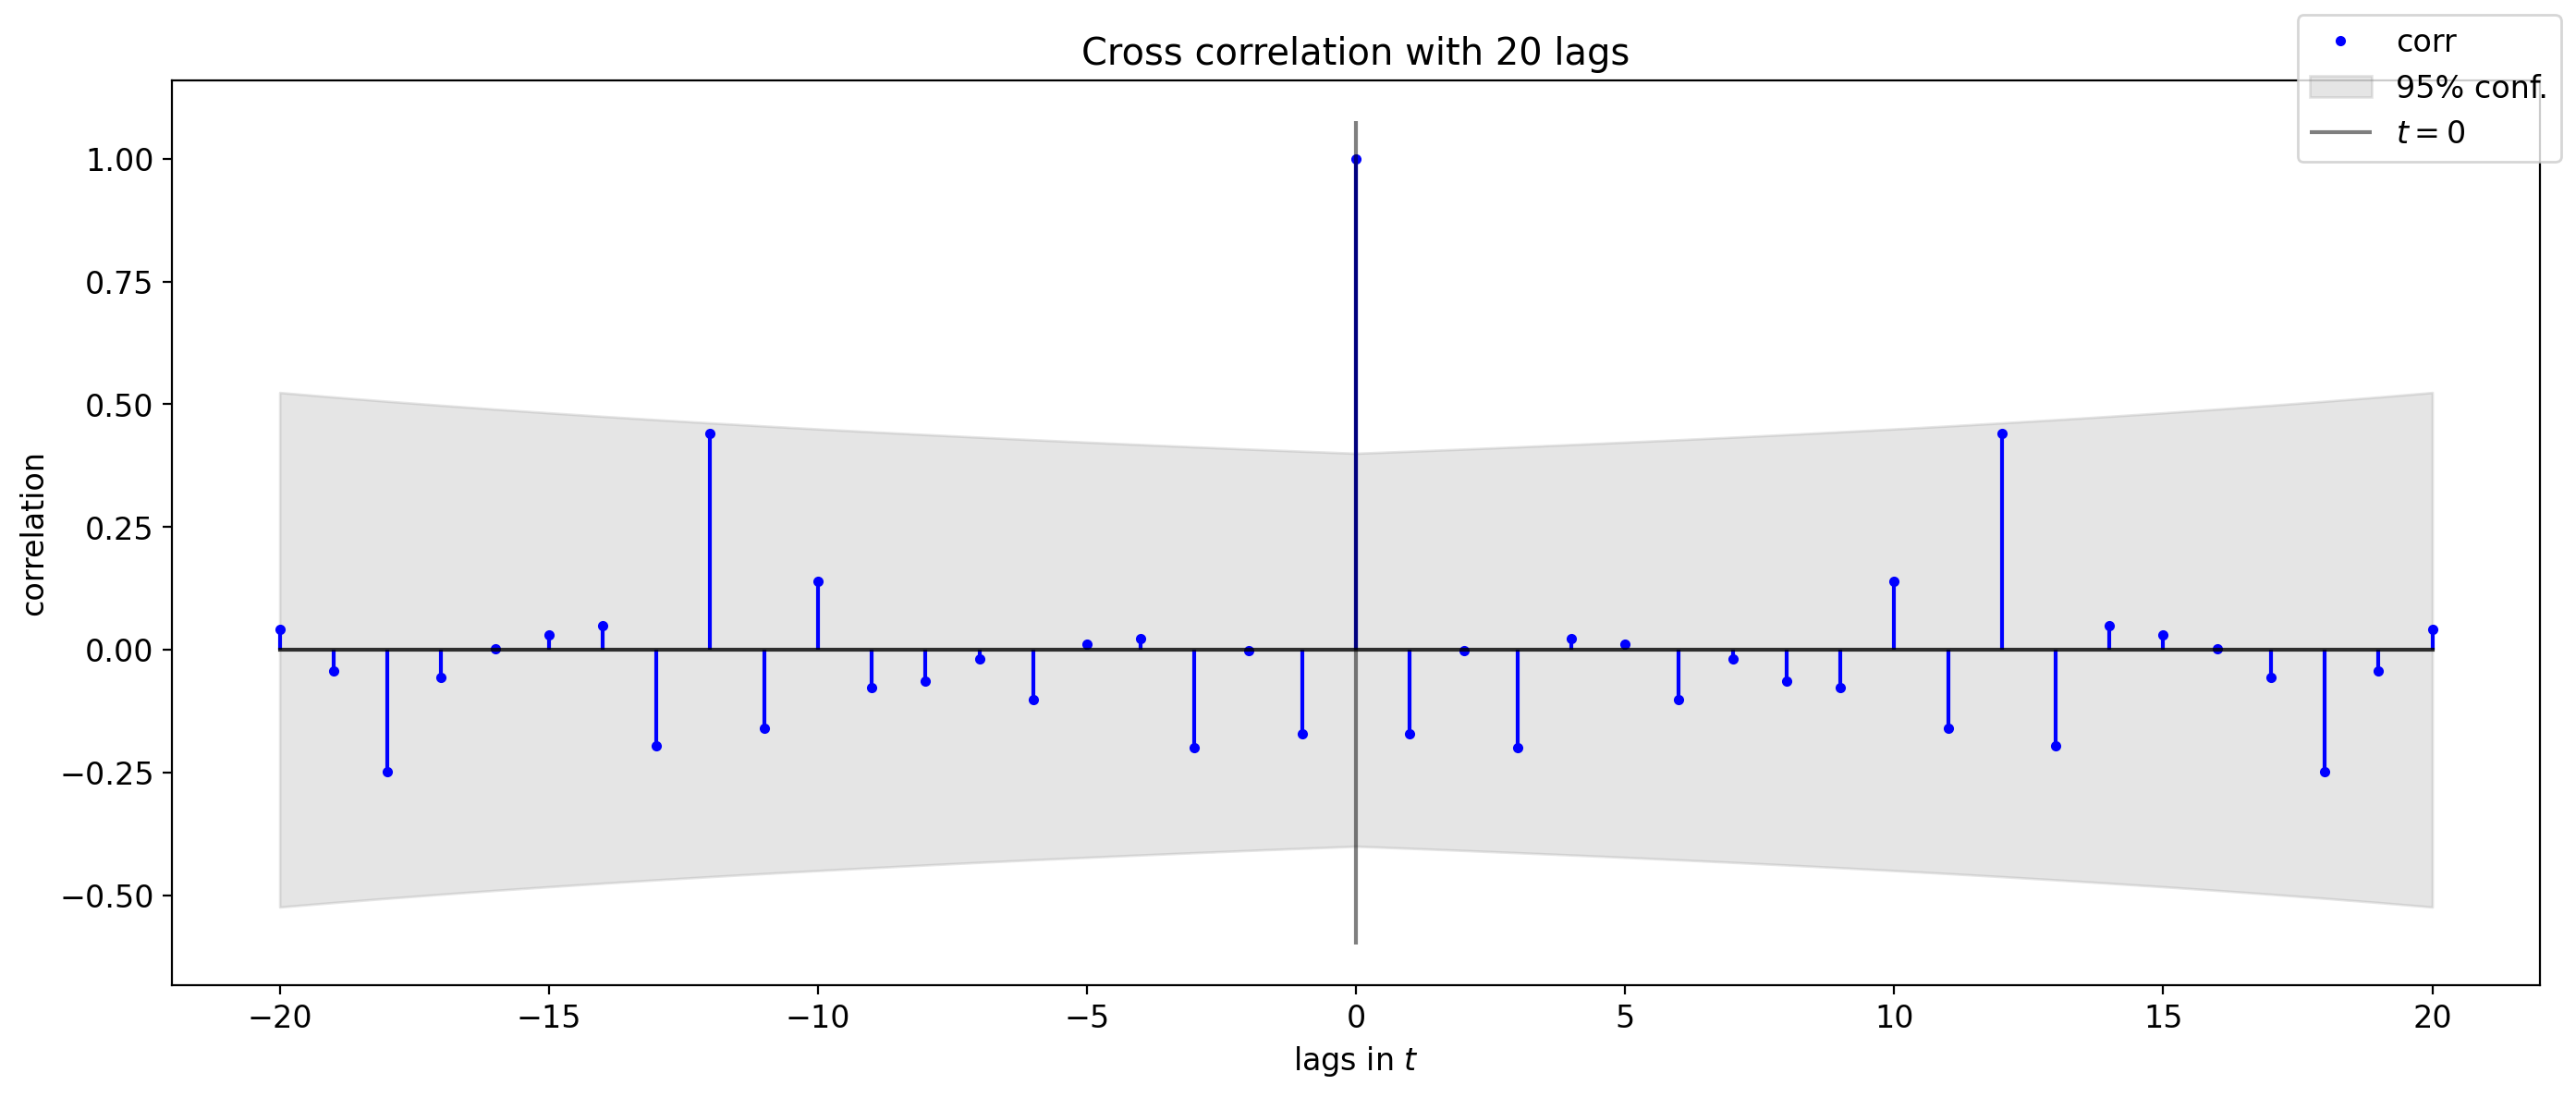

In [134]:
xcorr(df[~df.is_train]['pi_de_surprise'], n_lags=20);

# diff pi

In [62]:
%run init_notebook.py

In [63]:
from src.utils import load_pd_df, get_dt_index, Capturing, save_pd_df

In [64]:
# df = get_dt_index(load_pd_df('de_inf_prepro.csv'))

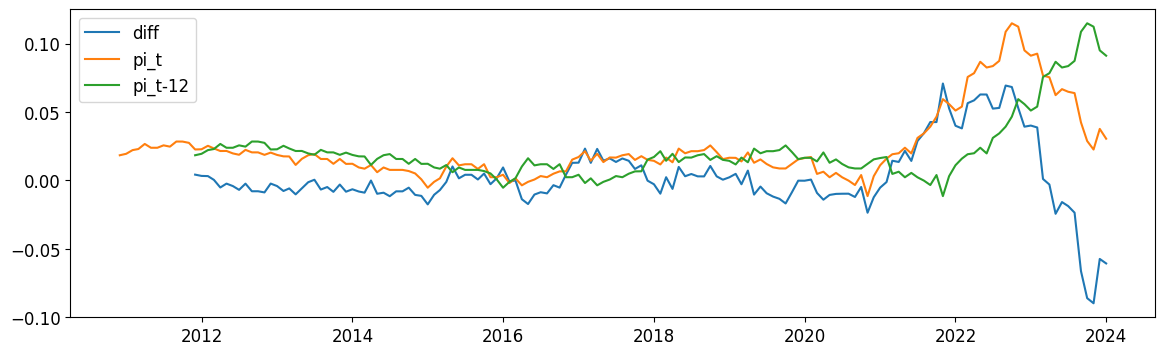

In [65]:
sub = df[['pi_de_Y']].reset_index().copy().dropna()
sub = sub.groupby('date').last().asfreq('MS')
# plt.plot(sub.shift(-12))
plt.plot(sub - sub.shift(12), label='diff')
plt.plot(sub, label='pi_t')
plt.plot(sub.shift(12), label='pi_t-12')
plt.legend()

sub['pi_de_Y_diff'] = sub - sub.shift(12)
df = df.join(sub.pi_de_Y_diff)

In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest, ttest_1samp

In [79]:
with Capturing(file_name='tab_data_ljung_box.txt', file_dir=GRAPHS_DIR) as output:
    for p, r in zip(["2010-01-01 to 2020-03-01", "2020-03-01 to 2023-12-31"], [resid, resid_test]):
        print("\n" + "-" * 50)
        print(f"Period: {p}")

        print("\nLjung Box test for residual autocorrelation: H0 data is indipendently distributed")
        print(acorr_ljungbox(r, boxpierce=True, model_df=1))

        print(f"\nTest for normality: H0 residual follows a normal distribution")
        [print(*i) for i in zip(['stats:', 'pval:'], [*normaltest(r)])];
    
        print(f"\nT-test: H0 the resiudal mean is equal to zero")
        [print(*i) for i in zip(['stats:', 'pval:'], [*ttest_1samp(r, 0)])]
;

''

In [72]:
[print(i) for i in output];


--------------------------------------------------
Period: 2010-01-01 to 2020-03-01

Ljung Box test for residual autocorrelation: H0 data is indipendently distributed
      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    0.049472        NaN   0.048245        NaN
2    0.164759   0.684813   0.159721   0.689414
3    0.521225   0.770579   0.501458   0.778233
4    6.435022   0.092261   6.122008   0.105823
5    7.421083   0.115240   7.051025   0.133216
6   11.340146   0.045038  10.710976   0.057421
7   15.223370   0.018589  14.305365   0.026405
8   15.436973   0.030789  14.501315   0.042950
9   16.331838   0.037869  15.314828   0.053305
10  16.378969   0.059377  15.357285   0.081578

Test for normality: H0 residual follows a normal distribution
stats: 0.03131528568513395
pval: 0.9844643007677194

T-test: H0 the resiudal mean is equal to zero
stats: 2.263538936978306
pval: 0.025430043325897572

--------------------------------------------------
Period: 2020-03-01 to 2023-09-01

Ljung Box test 

In [73]:
save_pd_df(df, "pi.feather")

In [185]:
# df.to_csv(os.path.join(DATA_DIR, 'de_inf_prepro.csv'))